In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
from lazypredict.Supervised import LazyClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import joblib

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier


from sklearn import metrics


#### Loading the dataset

In [2]:
penguins_raw = pd.read_csv('penguins_lter.csv')

In [3]:
penguins_raw.head(5)

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.10,18.70,181.00,3750.00,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.50,17.40,186.00,3800.00,FEMALE,8.95,-24.69,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.30,18.00,195.00,3250.00,FEMALE,8.37,-25.33,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.70,19.30,193.00,3450.00,FEMALE,8.77,-25.32,NaN


#### Understanding the dataset

In [4]:
penguins_raw['Region'].unique()

array(['Anvers'], dtype=object)

In [5]:
penguins_raw['Stage'].unique()

array(['Adult, 1 Egg Stage'], dtype=object)

In [6]:
penguins_raw['studyName'].unique()

array(['PAL0708', 'PAL0809', 'PAL0910'], dtype=object)

In [7]:
penguins_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            344 non-null    object 
 1   Sample Number        344 non-null    int64  
 2   Species              344 non-null    object 
 3   Region               344 non-null    object 
 4   Island               344 non-null    object 
 5   Stage                344 non-null    object 
 6   Individual ID        344 non-null    object 
 7   Clutch Completion    344 non-null    object 
 8   Date Egg             344 non-null    object 
 9   Culmen Length (mm)   342 non-null    float64
 10  Culmen Depth (mm)    342 non-null    float64
 11  Flipper Length (mm)  342 non-null    float64
 12  Body Mass (g)        342 non-null    float64
 13  Sex                  334 non-null    object 
 14  Delta 15 N (o/oo)    330 non-null    float64
 15  Delta 13 C (o/oo)    331 non-null    flo

In [8]:
penguins_raw.describe()

,Sample Number,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo)
count,344.00,342.00,342.00,342.00,342.00,330.00,331.00
mean,63.15,43.92,17.15,200.92,4201.75,8.73,-25.69
std,40.43,5.46,1.97,14.06,801.95,0.55,0.79
min,1.00,32.10,13.10,172.00,2700.00,7.63,-27.02
25%,29.00,39.23,15.60,190.00,3550.00,8.30,-26.32
50%,58.00,44.45,17.30,197.00,4050.00,8.65,-25.83
75%,95.25,48.50,18.70,213.00,4750.00,9.17,-25.06
max,152.00,59.60,21.50,231.00,6300.00,10.03,-23.79


In [9]:
penguins_raw.isnull().sum()/len(penguins_raw)*100

studyName              0.00
Sample Number          0.00
Species                0.00
Region                 0.00
Island                 0.00
Stage                  0.00
Individual ID          0.00
Clutch Completion      0.00
Date Egg               0.00
Culmen Length (mm)     0.58
Culmen Depth (mm)      0.58
Flipper Length (mm)    0.58
Body Mass (g)          0.58
Sex                    2.91
Delta 15 N (o/oo)      4.07
Delta 13 C (o/oo)      3.78
Comments              92.44
dtype: float64

#### Data Cleaning

In [10]:
def clean(data:pd.DataFrame):
   peng = data.drop(["Comments"],axis=1)
   peng["Species"] = peng.Species.str.split(n=1,expand=True)[0]
   peng.drop(columns=['Region', 'Stage', 'Individual ID', 'Sample Number', 'studyName','Date Egg'],inplace=True)
   original_columns =peng.columns.to_list()
   peng.columns = ['species','island','clutch','culmenL','culmenD','flipperL','bmass','sex','delta_15n','delta_13c']
   return peng

In [11]:
peng_process = clean(penguins_raw)

peng_process.head()

,species,island,clutch,culmenL,culmenD,flipperL,bmass,sex,delta_15n,delta_13c
0,Adelie,Torgersen,Yes,39.10,18.70,181.00,3750.00,MALE,NaN,NaN
1,Adelie,Torgersen,Yes,39.50,17.40,186.00,3800.00,FEMALE,8.95,-24.69
2,Adelie,Torgersen,Yes,40.30,18.00,195.00,3250.00,FEMALE,8.37,-25.33
3,Adelie,Torgersen,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,Yes,36.70,19.30,193.00,3450.00,FEMALE,8.77,-25.32


In [12]:
unique = peng_process.apply(pd.Series.unique)

unique

species                            [Adelie, Chinstrap, Gentoo]
island                              [Torgersen, Biscoe, Dream]
clutch                                               [Yes, No]
culmenL      [39.1, 39.5, 40.3, nan, 36.7, 39.3, 38.9, 39.2...
culmenD      [18.7, 17.4, 18.0, nan, 19.3, 20.6, 17.8, 19.6...
flipperL     [181.0, 186.0, 195.0, nan, 193.0, 190.0, 180.0...
bmass        [3750.0, 3800.0, 3250.0, nan, 3450.0, 3650.0, ...
sex                                     [MALE, FEMALE, nan, .]
delta_15n    [nan, 8.94956, 8.36821, 8.76651, 8.66496, 9.18...
delta_13c    [nan, -24.69454, -25.33302, -25.32426, -25.298...
dtype: object

In [15]:
peng_process.delta_13c.min()

-27.01854

In [17]:
peng_process.delta_13c.max()

-23.78767

In [120]:
peng_process.sex.unique()

array(['MALE', 'FEMALE', nan, '.'], dtype=object)

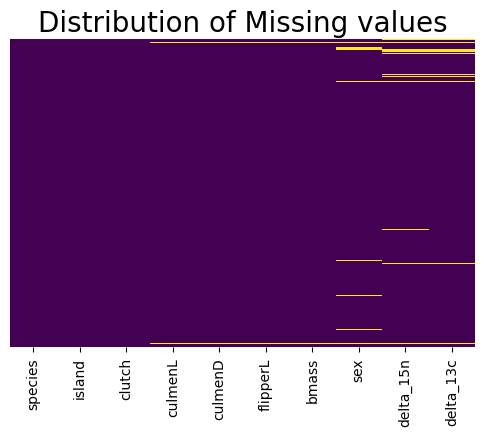

In [121]:
plt.figure(figsize=(6, 4))
sns.heatmap(peng_process.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Distribution of Missing values", fontsize=20)
plt.show()

#### Some Feature Engineering

In [122]:
peng_quin = peng_process.copy()

In [123]:
bins_1 = [35, 45, 55, 65]
groups = ["short", "medium", "long"]
peng_quin["culmenL_cat"] = pd.cut(peng_quin["culmenL"], bins_1, labels=groups)

In [124]:
bins_2 = [14, 17, 20, 23]
groups = ["short", "medium", "long"]
peng_quin["culmenD_cat"] = pd.cut(peng_quin["culmenD"], bins_2, labels=groups)

In [125]:
bins = [180, 200, 220, 240]
groups = ["short", "medium", "long"]
peng_quin["flipperL_cat"] = pd.cut(peng_quin["flipperL"], bins, labels=groups)

In [126]:
bins = [ 2500, 4000, 5500, 7000]
groups = ["Light Weight", "Medium Weight", "Heavy Weight"]
peng_quin["bmass_cat"] = pd.cut(peng_quin["bmass"], bins, labels=groups)

### Exploratory Data Analysis

#### Univariate Analysis

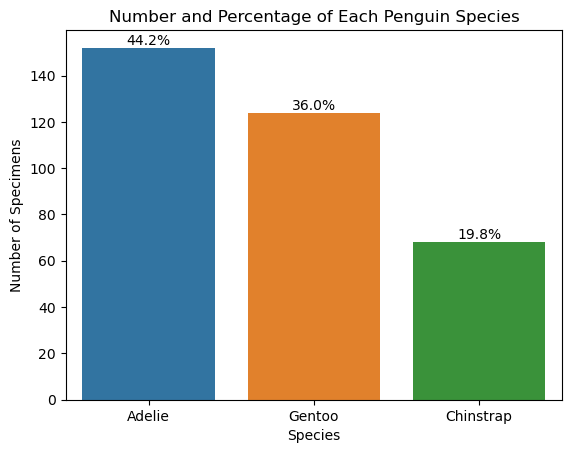

In [127]:
total = peng_quin.shape[0]
penguins = sns.countplot(x=peng_quin.species, order=peng_quin.species.value_counts().index)

for p in penguins.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    
    penguins.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10, color='black')
    
#     penguins.text(p.get_x() + p.get_width() / 2, p.get_height(), str(int(p.get_height())), ha='center', va='top', fontsize=10, color='white', fontweight='bold')

plt.title("Number and Percentage of Each Penguin Species")
plt.xlabel('Species')
plt.ylabel('Number of Specimens')

plt.show()


from above, it is evident that Adelie has the highest population in the dataset

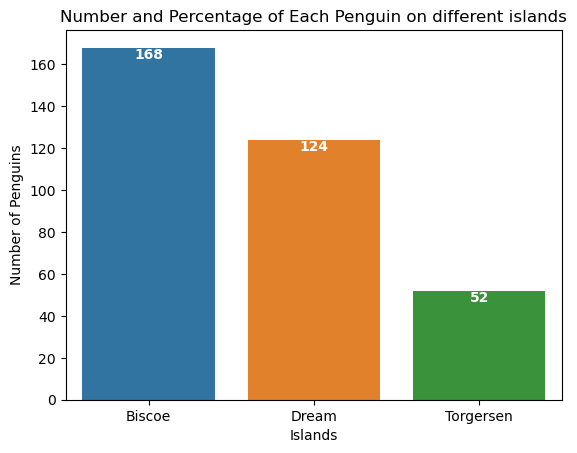

In [128]:
total = peng_quin.shape[0]
penguins = sns.countplot(x=peng_quin.island, order=peng_quin.island.value_counts().index)

for p in penguins.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    
#     penguins.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10, color='black')
    
    penguins.text(p.get_x() + p.get_width() / 2, p.get_height(), str(int(p.get_height())), ha='center', va='top', fontsize=10, color='white', fontweight='bold')

plt.title("Number and Percentage of Each Penguin on different islands")
plt.xlabel('Islands')
plt.ylabel('Number of Penguins')

plt.show()

Biscoe Island has the highest population of Penguins, while Torgersen

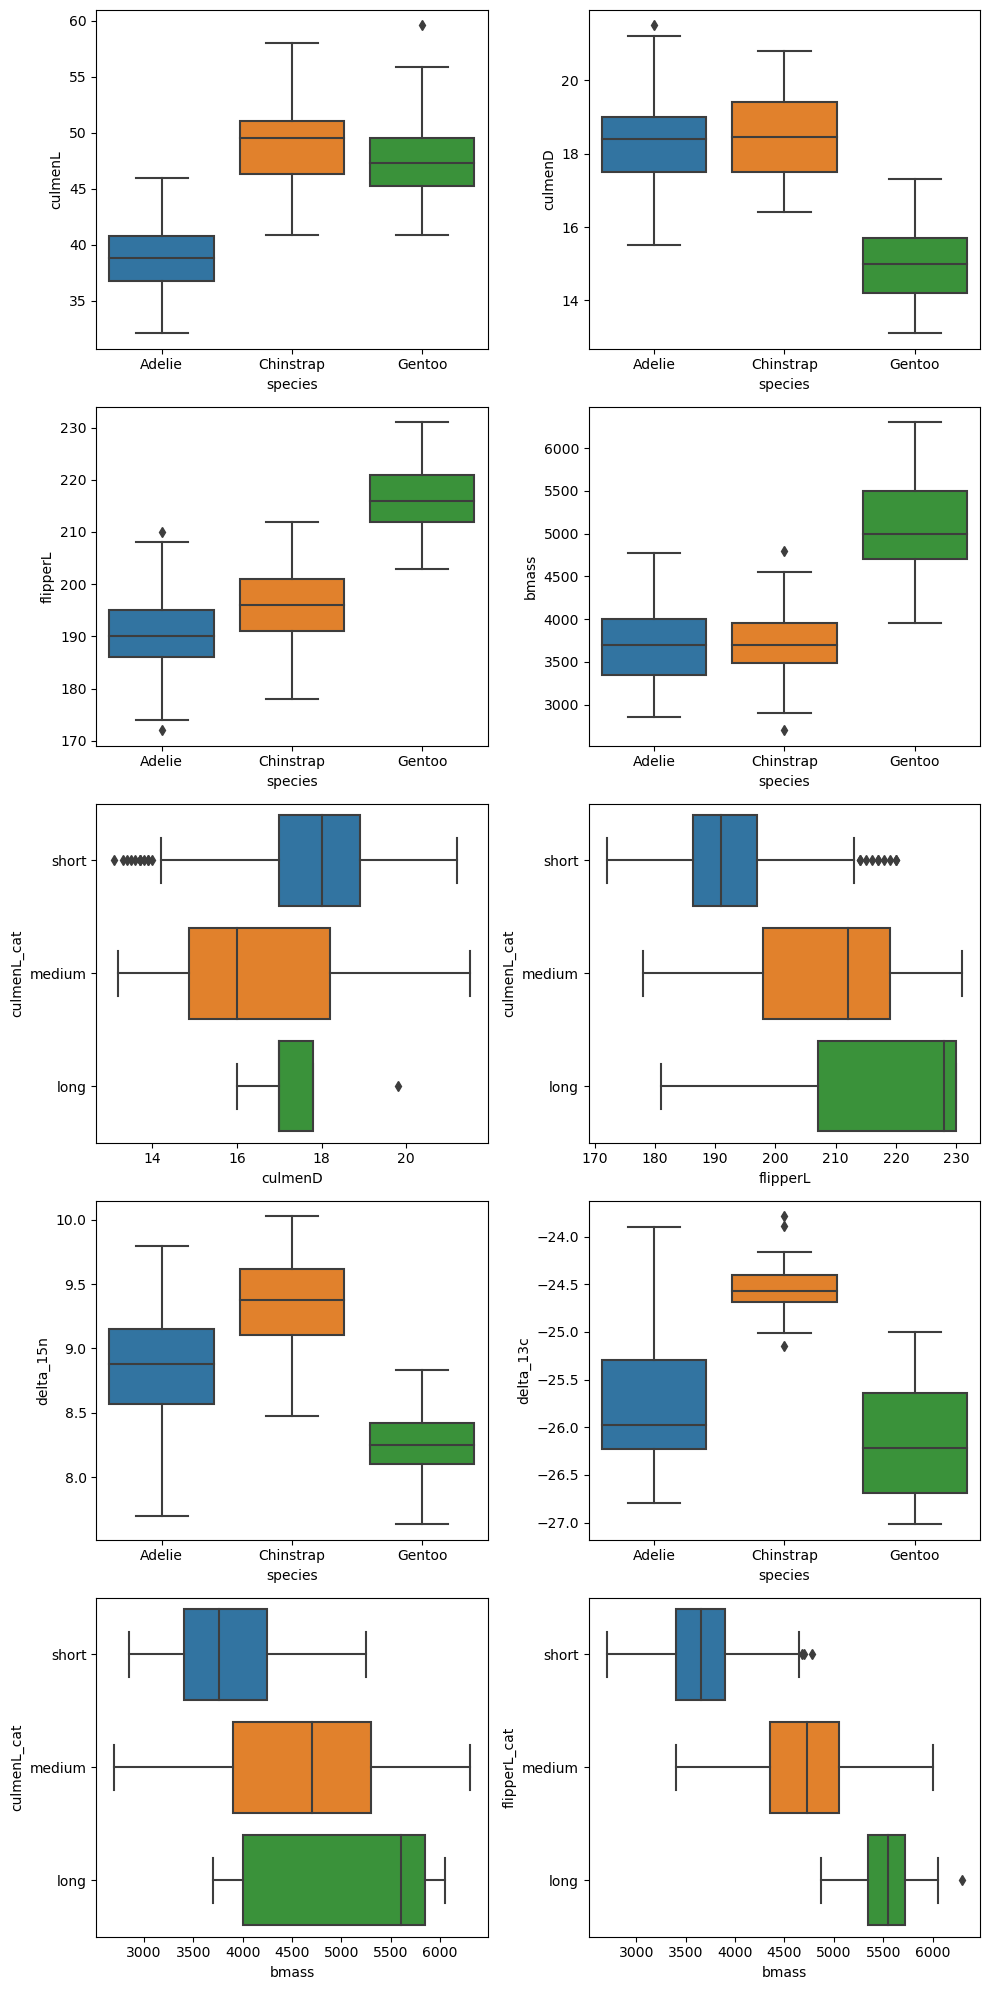

In [129]:
plt.figure(figsize=(10, 20))
plt.subplot(5,2,1)
sns.boxplot(y = 'culmenL', x = 'species', data = peng_quin)
plt.subplot(5,2,2)
sns.boxplot(y = 'culmenD', x = 'species', data = peng_quin)
plt.subplot(5,2,3)
sns.boxplot(y = 'flipperL', x = 'species', data = peng_quin)
plt.subplot(5,2,4)
sns.boxplot(y = 'bmass', x = 'species', data = peng_quin)
plt.subplot(5,2,5)
sns.boxplot(y = 'culmenL_cat', x = 'culmenD', data = peng_quin)
plt.subplot(5,2,6)
sns.boxplot(y = 'culmenL_cat', x = 'flipperL', data = peng_quin)
plt.subplot(5,2,7)
sns.boxplot(y = 'delta_15n', x = 'species', data = peng_quin)
plt.subplot(5,2,8)
sns.boxplot(y = 'delta_13c', x = 'species', data = peng_quin)
plt.subplot(5,2,9)
sns.boxplot(y = 'culmenL_cat', x = 'bmass', data = peng_quin)
plt.subplot(5,2,10)
sns.boxplot(y = 'flipperL_cat', x = 'bmass', data = peng_quin)
plt.tight_layout()
plt.show()

A few outliers can be found between in the dataset

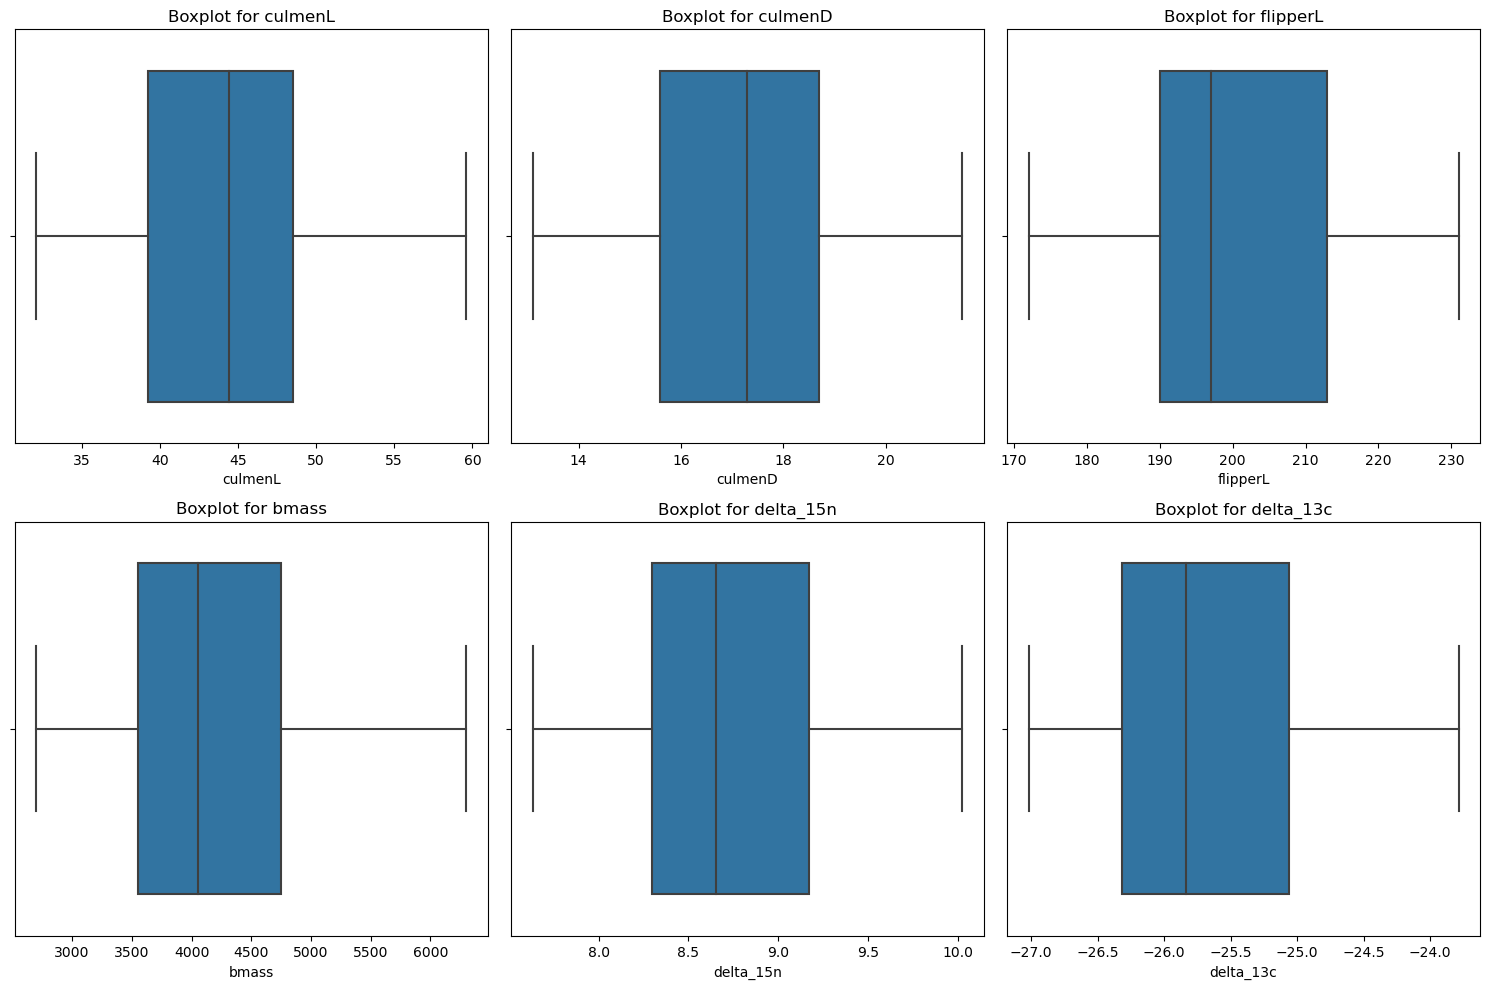

In [130]:
cat = peng_quin[['culmenL', 'culmenD', 'flipperL', 'bmass', 'delta_15n', 'delta_13c']]

num_rows, num_cols = 2, 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

axes = axes.flatten()

for i, column in enumerate(cat.columns):
    sns.boxplot(data=cat, x=column, ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

# Remove any remaining empty subplots
for j in range(len(cat.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

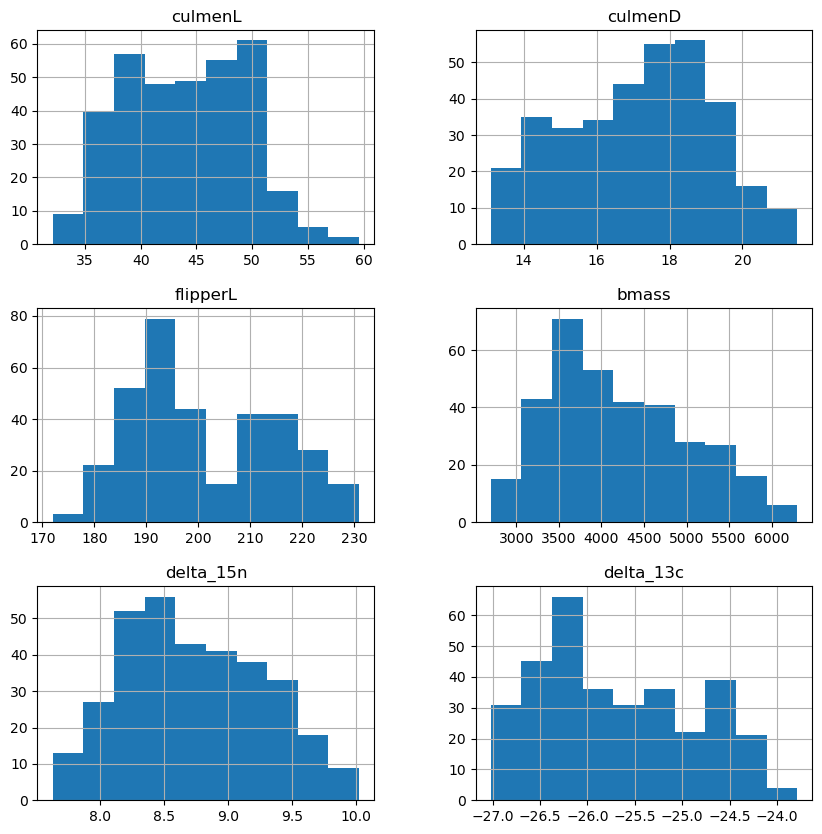

In [131]:
peng_process.hist(figsize = (10,10))
plt.show()

#### Multivariate Analysis

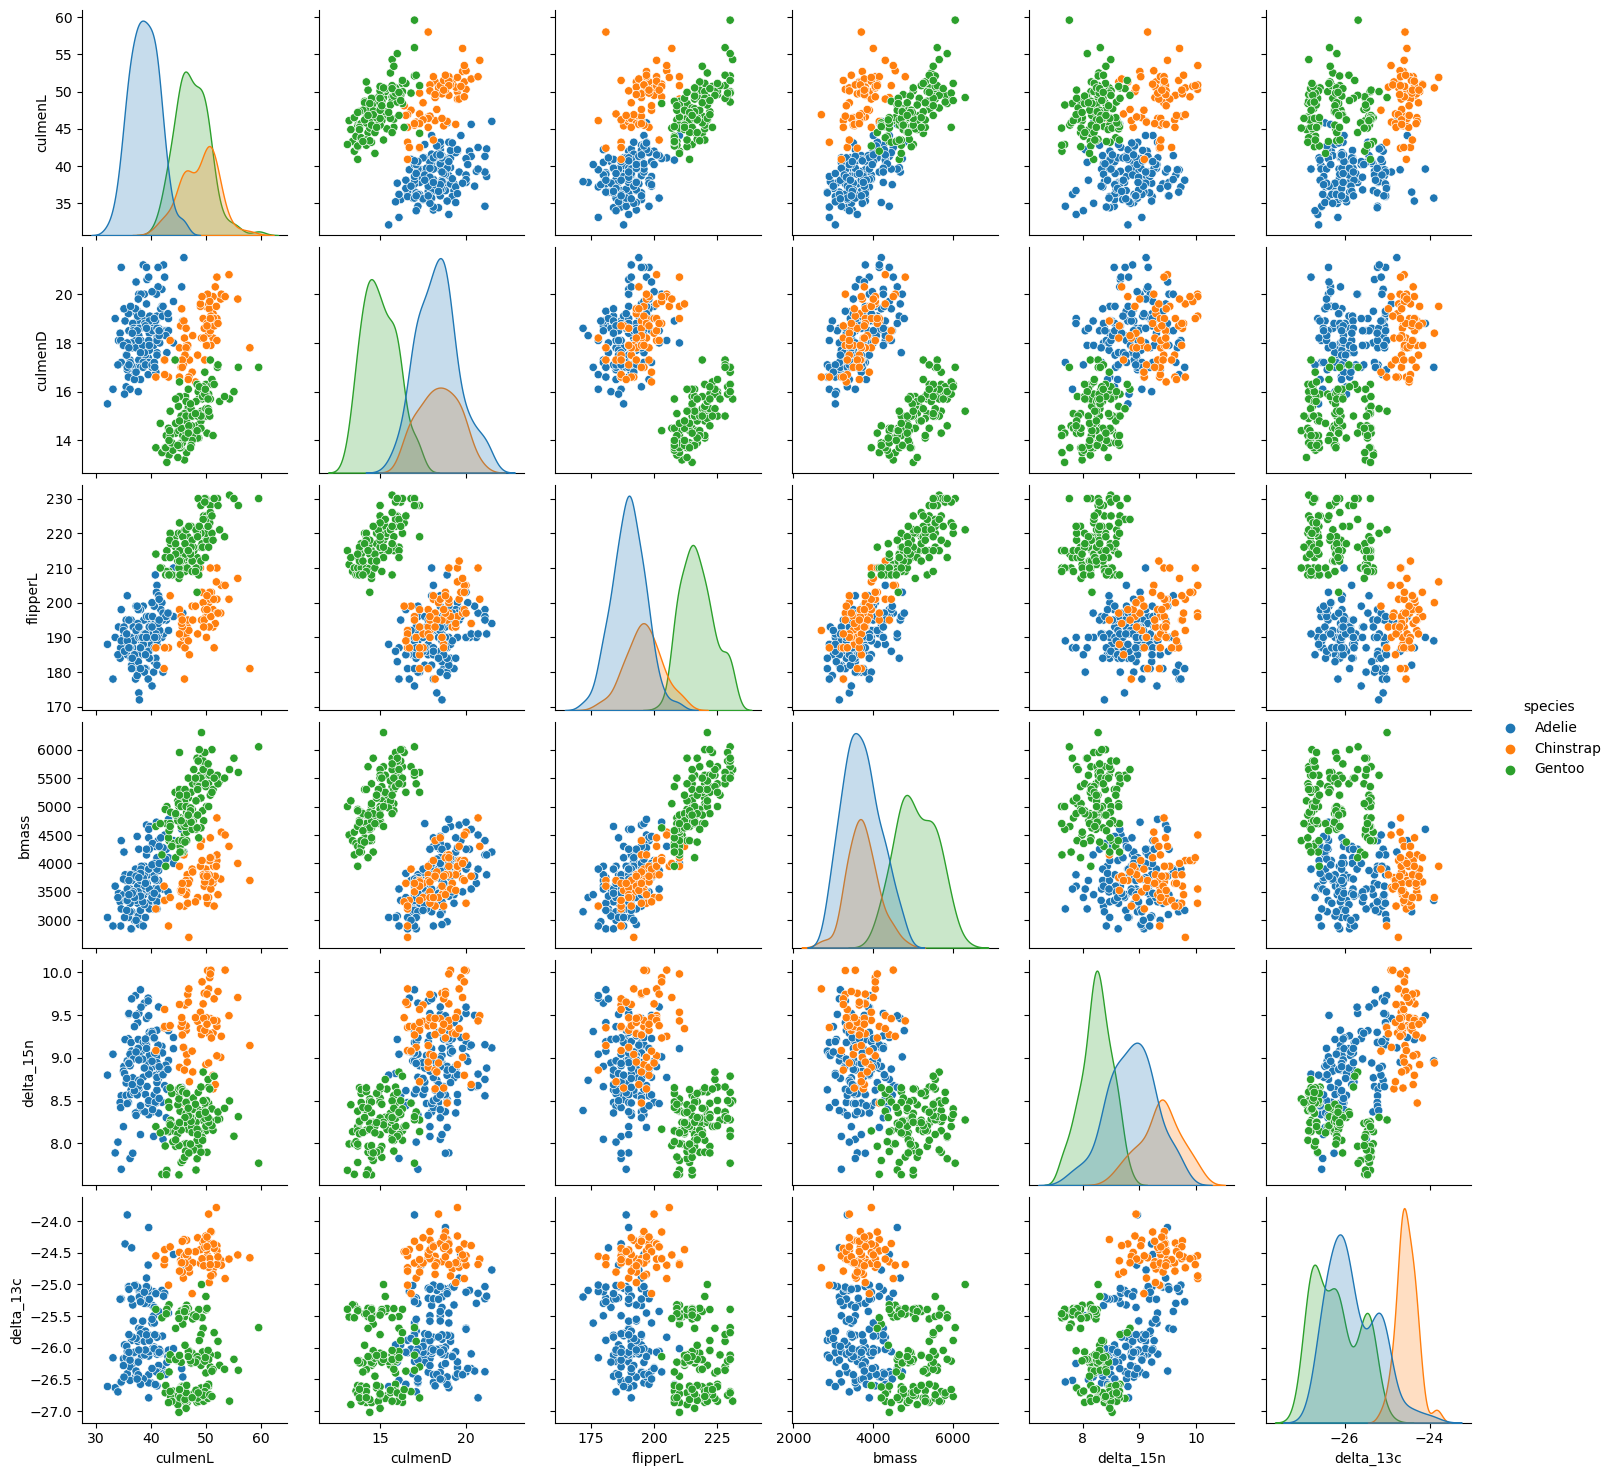

In [132]:
sns.pairplot(data = peng_process, hue = 'species')
plt.show()

<Axes: >

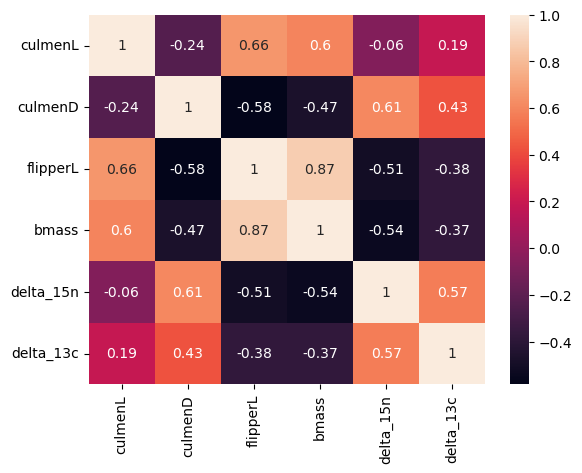

In [133]:
sns.heatmap(peng_process.corr(), annot=True)

##### During the Bivariate analysis, column was giving nan as a category, so, i decided to investigate and drop the rows involved

In [134]:
peng_quin['sex'].loc[peng_process['sex'] == "."].dropna().index.tolist()

[336]

In [135]:
peng_quin.drop(index=336, inplace = True)

In [136]:
peng_quin.dropna(inplace=True)

In [137]:
peng_quin.sex.unique()

array(['FEMALE', 'MALE'], dtype=object)

In [138]:
peng_quin.sex.unique()

array(['FEMALE', 'MALE'], dtype=object)

#### Bivariate Analysis

Text(0, 0.5, 'Number of Penguins')

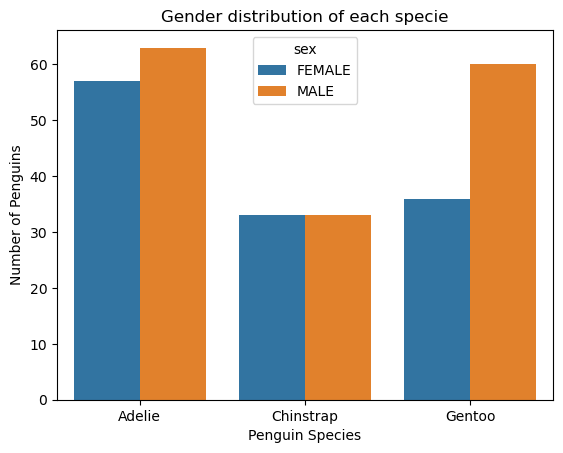

In [139]:
sns.countplot(data=peng_quin, x = "species", hue="sex")
plt.title("Gender distribution of each specie")
plt.xlabel('Penguin Species')
plt.ylabel('Number of Penguins')

Gentoo and Adelie specie has more Male, while Chinstrap has an equal number of both sexes but with a lower total population when compared to the other two species

Text(0.5, 1.0, 'Culmen Length vs Species')

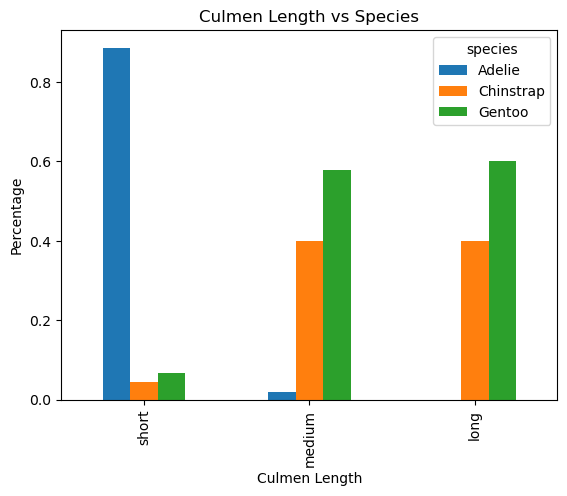

In [140]:
culmen_bin = pd.crosstab(peng_quin["culmenL_cat"], peng_quin["species"])
culmen_bin.div(culmen_bin.sum(1).astype(float), axis=0).plot(kind="bar")
plt.xlabel("Culmen Length")
plt.ylabel("Percentage")
plt.title("Culmen Length vs Species")

Adelie has more of shorter Culmen length, Gentoo and Chinstrap has more of medium and long Culmen length

Text(0.5, 1.0, 'Culmen Depth vs Species')

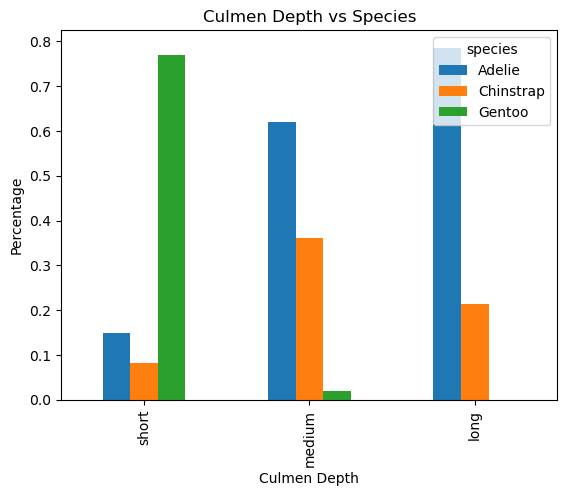

In [141]:
culmenD_bin = pd.crosstab(peng_quin["culmenD_cat"], peng_quin["species"])
culmenD_bin.div(culmenD_bin.sum(1).astype(float), axis=0).plot(kind="bar")
plt.xlabel("Culmen Depth")
plt.ylabel("Percentage")
plt.title("Culmen Depth vs Species")

Gentoo specie has more shorter Culmen depths, Chinstrap specie has more Medium sized Culmem depths, while Adelie specie has the Longest Culmen Depth

Text(0.5, 1.0, 'Flipper Length vs Species')

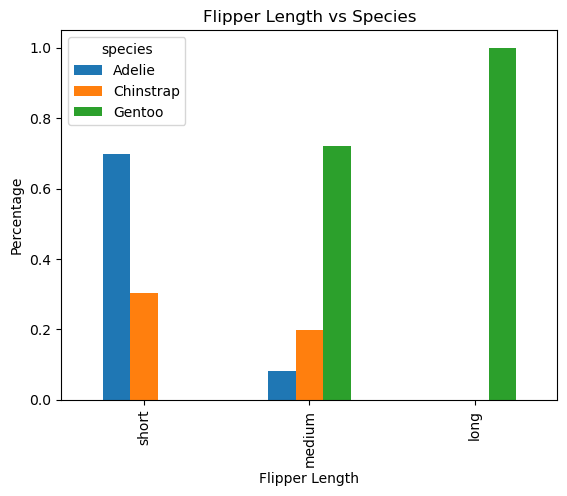

In [142]:
flipper_bin = pd.crosstab(peng_quin["flipperL_cat"], peng_quin["species"])
flipper_bin.div(flipper_bin.sum(1).astype(float), axis=0).plot(kind="bar")
plt.xlabel("Flipper Length")
plt.ylabel("Percentage")
plt.title("Flipper Length vs Species")

Adelie and Chinstrap Specie has more Short flipper length, while Gentoo Specie has more long flipper length

Text(0.5, 1.0, 'Body Mass vs Species')

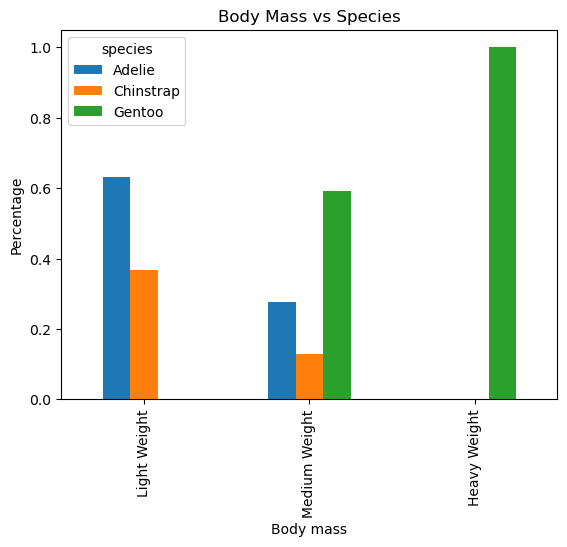

In [143]:
bmass_bins = pd.crosstab(peng_quin["bmass_cat"], peng_quin["species"])
bmass_bins.div(bmass_bins.sum(1).astype(float), axis=0).plot(kind="bar")
plt.xlabel("Body mass")
plt.ylabel("Percentage")
plt.title("Body Mass vs Species")

Gentoo Specie has the highest number of Heavy Weight, while Chinstrap and Gentoo Specie are more of Lightweight Penguins

Text(0, 0.5, 'Number of Penguin')

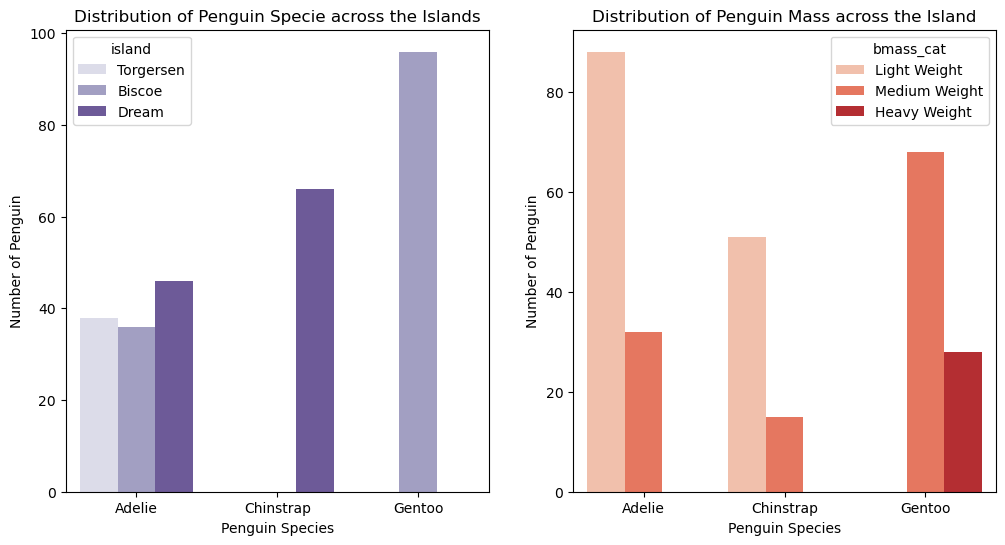

In [144]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(data=peng_quin, x= "species", hue="island", palette="Purples")
plt.title("Distribution of Penguin Specie across the Islands")
plt.xlabel('Penguin Species')
plt.ylabel('Number of Penguin');

plt.subplot(1,2,2)
sns.countplot(data=peng_quin, x= "species", hue="bmass_cat", palette="Reds")
plt.title("Distribution of Penguin Mass across the Island")
plt.xlabel('Penguin Species')
plt.ylabel('Number of Penguin')

Adelie Species are mostly lightweight Penguin and are mostly found on Dream Island. they can also be found in Torgesen and Biscoe Island.<br/>
Chinstrap Specie are mostly lightweight as well, and can be found on Dream Island<br/>
Gentoo Specie are mostly medium weight and can be sometimes Heavy weight. they can be found mostly on Biscoe Island

Text(0, 0.5, 'Number of Penguins')

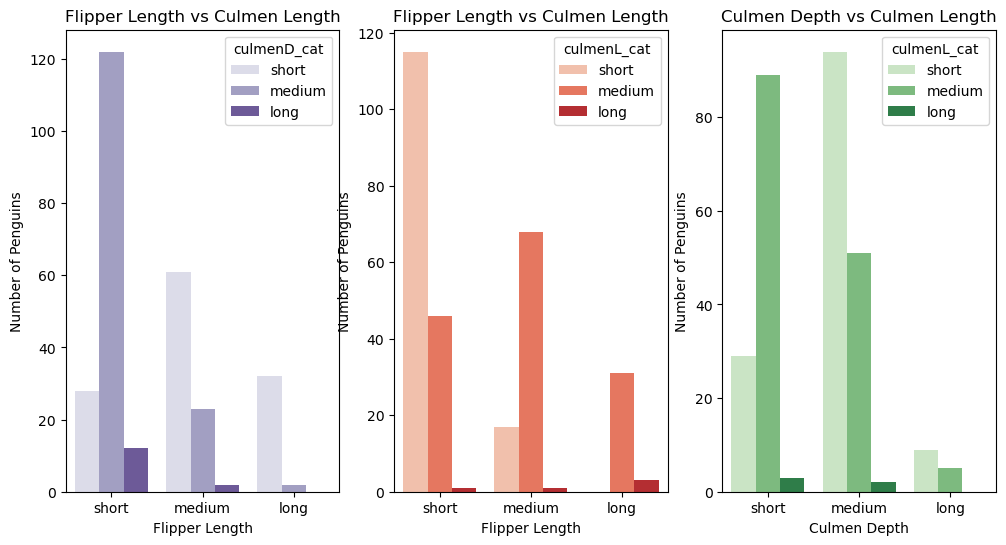

In [145]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
sns.countplot(data=peng_quin, x= "flipperL_cat", hue="culmenD_cat", palette="Purples")
plt.title("Flipper Length vs Culmen Length")
plt.xlabel('Flipper Length')
plt.ylabel('Number of Penguins');

plt.subplot(1,3,2)
sns.countplot(data=peng_quin, x= "flipperL_cat", hue="culmenL_cat", palette="Reds")
plt.title("Flipper Length vs Culmen Length")
plt.xlabel('Flipper Length')
plt.ylabel('Number of Penguins')

plt.subplot(1,3,3)
sns.countplot(data=peng_quin, x= "culmenD_cat", hue="culmenL_cat", palette="Greens")
plt.title("Culmen Depth vs Culmen Length")
plt.xlabel('Culmen Depth')
plt.ylabel('Number of Penguins')

Most Penguins with short Flipper length have medium sized Culmen depth and short Culmen length<br/>
Most Penguins with medium Flipper length have short Culmen depth and short Culmen length<br/>
Most Penguins with long Flipper length has medium sized Culmen length and short Culmen depth 

Text(0, 0.5, 'Number of Penguins')

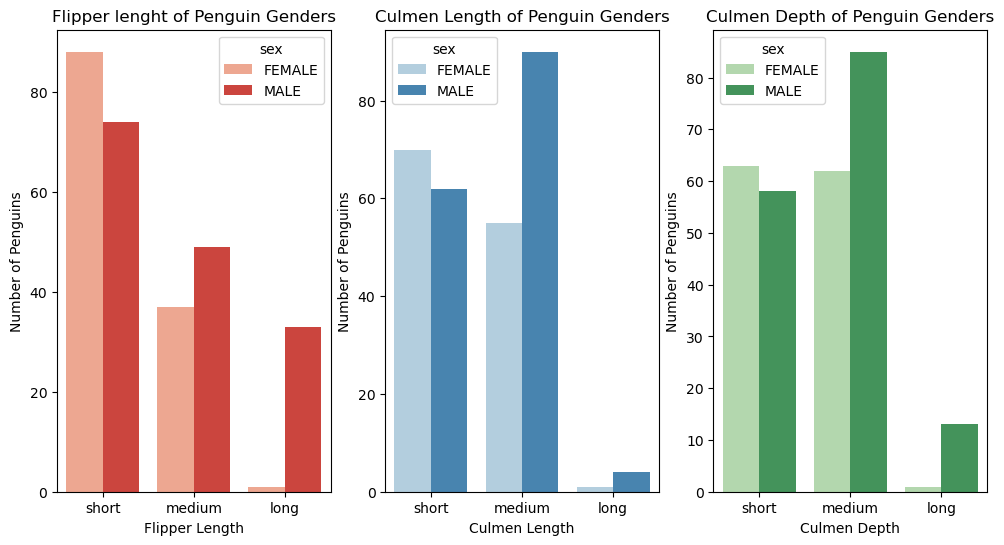

In [146]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
sns.countplot(data=peng_quin, x= "flipperL_cat", hue="sex", palette="Reds")
plt.title("Flipper lenght of Penguin Genders");
plt.xlabel('Flipper Length')
plt.ylabel('Number of Penguins')

plt.subplot(1,3,2)
sns.countplot(data=peng_quin, x= "culmenL_cat", hue="sex", palette="Blues")
plt.title("Culmen Length of Penguin Genders")
plt.xlabel('Culmen Length')
plt.ylabel('Number of Penguins')

plt.subplot(1,3,3)
sns.countplot(data=peng_quin, x= "culmenD_cat", hue="sex", palette="Greens")
plt.title("Culmen Depth of Penguin Genders")
plt.xlabel('Culmen Depth')
plt.ylabel('Number of Penguins')

there are more female penguins with Short flipper length while Male penguins have longer flipper length<br/>
Female Penguins tend to have shorter Culmen length, while Male Penguin tend to have more longer Culmen length<br/>
Female penguin have Short and Medium sized Culmen depth while male penguins have more medium sized Culmen length  

Text(0, 0.5, 'Number of Penguins')

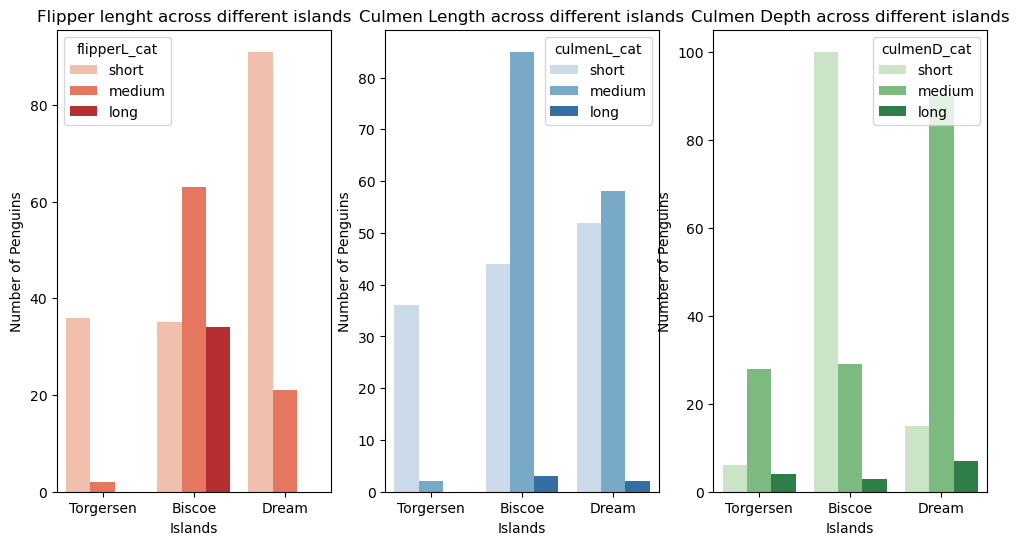

In [147]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
sns.countplot(data=peng_quin, x= "island", hue="flipperL_cat", palette="Reds")
plt.title("Flipper lenght across different islands");
plt.xlabel('Islands')
plt.ylabel('Number of Penguins')

plt.subplot(1,3,2)
sns.countplot(data=peng_quin, x= "island", hue="culmenL_cat", palette="Blues")
plt.title("Culmen Length across different islands")
plt.xlabel('Islands')
plt.ylabel('Number of Penguins')

plt.subplot(1,3,3)
sns.countplot(data=peng_quin, x= "island", hue="culmenD_cat", palette="Greens")
plt.title("Culmen Depth across different islands")
plt.xlabel('Islands')
plt.ylabel('Number of Penguins')

Torgesen Island has penguins with more short flipper length, short Culmen length and medium sized Culmen depth<br/>
Biscoe Island has more Medium sized Flipper length, medium sized Culmen length and short sized Culmen depth<br/>
Dream Island has most Short Flipper length, medium and short sized Culmen length and medium sized Culmen depth

Text(0, 0.5, 'Number of Penguins')

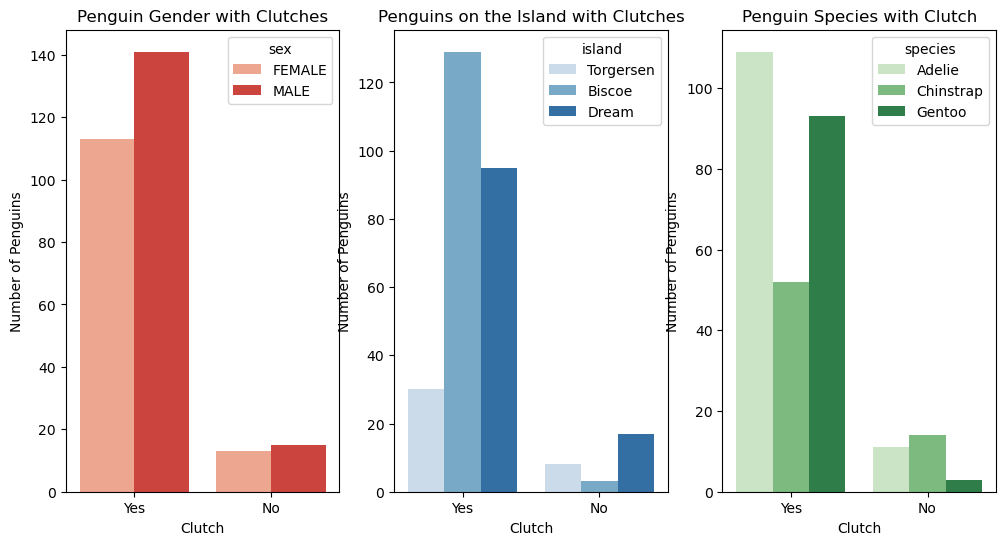

In [148]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
sns.countplot(data=peng_quin, x = "clutch", hue="sex", palette="Reds")
plt.title("Penguin Gender with Clutches")
plt.xlabel('Clutch')
plt.ylabel('Number of Penguins')

plt.subplot(1,3,2)
sns.countplot(data=peng_quin, x = "clutch", hue="island", palette="Blues")
plt.title("Penguins on the Island with Clutches")
plt.xlabel('Clutch')
plt.ylabel('Number of Penguins')

plt.subplot(1,3,3)
sns.countplot(data=peng_quin, x = "clutch", hue="species", palette="Greens")
plt.title("Penguin Species with Clutch")
plt.xlabel('Clutch')
plt.ylabel('Number of Penguins')

Most Penguins with Clutch are Male, can be found in Biscoe Island, and are of the Adelie Specie<br/>
Most penguins without Clutches belong to both male and female penguins, are found on Dream Island, and belong to the Chinstrap Specie, 

### Data Preprocessing

In [149]:
peng_enc = peng_quin.drop(columns = ['culmenL_cat', 'culmenD_cat', 'flipperL_cat', 'bmass_cat'], axis = 0)

In [150]:
# peng_enc['culmenL_D'] = peng_enc['culmenL']/peng_enc['culmenD']

In [151]:
# peng_enc['culmenL_fl'] = peng_enc['culmenL']/peng_enc['flipperL']

In [152]:
# peng_enc['culmenD_fl'] = peng_enc['culmenD']/peng_enc['flipperL']

In [153]:
col_to_encode = ["species", "island", "clutch", 'sex']

label_encoder = LabelEncoder()
for col in col_to_encode:
    peng_enc[col] = label_encoder.fit_transform(peng_enc[col])

In [154]:
X = peng_enc.drop(columns=['species'])
y = peng_enc[['species']]

In [155]:
X 

,island,clutch,culmenL,culmenD,flipperL,bmass,sex,delta_15n,delta_13c
1,2,1,39.50,17.40,186.00,3800.00,0,8.95,-24.69
2,2,1,40.30,18.00,195.00,3250.00,0,8.37,-25.33
4,2,1,36.70,19.30,193.00,3450.00,0,8.77,-25.32
5,2,1,39.30,20.60,190.00,3650.00,1,8.66,-25.30
6,2,0,38.90,17.80,181.00,3625.00,0,9.19,-25.22
...,...,...,...,...,...,...,...,...,...
337,0,1,48.80,16.20,222.00,6000.00,1,8.34,-25.89
340,0,1,46.80,14.30,215.00,4850.00,0,8.41,-26.14
341,0,1,50.40,15.70,222.00,5750.00,1,8.30,-26.04
342,0,1,45.20,14.80,212.00,5200.00,0,8.24,-26.12


In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [157]:
print('X_train is:', X_train.shape)
print('y_train is :', y_train.shape)
print('X_test is:', X_test.shape)
print('y_test is :', y_test.shape)

X_train is: (225, 9)
y_train is : (225, 1)
X_test is: (57, 9)
y_test is : (57, 1)


In [158]:
possible_algos = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
models, predictions = possible_algos.fit(X_train, X_test, y_train, y_test)

 97%|█████████▋| 28/29 [00:06<00:00,  3.75it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 9
[LightGBM] [Info] Start training from score -0.851752
[LightGBM] [Info] Start training from score -1.445808
[LightGBM] [Info] Start training from score -1.085367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 29/29 [00:07<00:00,  4.09it/s]


In [159]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,1.00,1.00,None,1.00,0.11
LogisticRegression,1.00,1.00,None,1.00,0.17
XGBClassifier,1.00,1.00,None,1.00,0.57
SVC,1.00,1.00,None,1.00,0.12
SGDClassifier,1.00,1.00,None,1.00,0.14
RidgeClassifierCV,1.00,1.00,None,1.00,0.20
RidgeClassifier,1.00,1.00,None,1.00,0.19
RandomForestClassifier,1.00,1.00,None,1.00,1.49
Perceptron,1.00,1.00,None,1.00,0.11


#### Logistic Regression

In [160]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

Accuracy: 100.00%


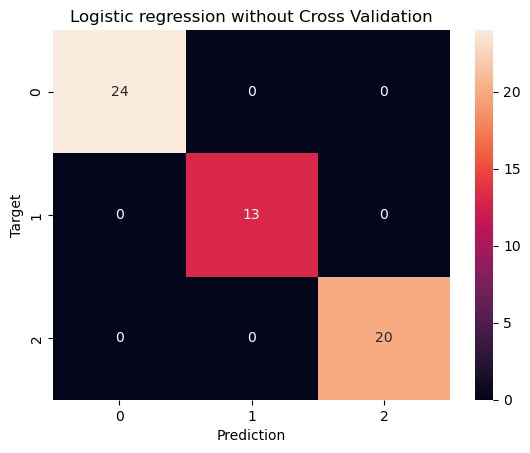

In [161]:
def predict_and_plot(model, inputs, targets):
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Logistic regression without Cross Validation')
    
    return preds
val_preds = predict_and_plot(log_reg, X_test, y_test)

##### Logistic regression with Hyperparameter tuning

In [162]:
#using Gridsearch to find the best hyperparameter combination for the logistic regression model

from sklearn.linear_model import LogisticRegression

para = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [100, 200, 300]
}
       
log_reg2 = LogisticRegression()
    
grid = GridSearchCV(log_reg2, para)
grid.fit(X_train, y_train)

best_params = grid.best_params_
best_score = grid.best_score_

print('Best parameter:', best_params)
print('Best score:', best_score)

Best parameter: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 1.0


In [163]:
AccuracyScore = []
f1score =[]
RecallScore = []
PrecisionScore = []

params = {
    'C': 0.1,
    'penalty': 'l2',
    'solver': 'liblinear',
    'max_iter': 100
}

fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    log_reg = LogisticRegression(**params)
    log_reg.fit(X_train, y_train)

    logi_reg = log_reg.predict(X_test)
    acc_score= accuracy_score(y_test, logi_reg)
    f1 = f1_score(y_test, logi_reg, average='weighted')
    recall= recall_score(y_test, logi_reg, average='weighted')
    precision= precision_score(y_test, logi_reg, average='weighted')
    
AccuracyScore.append(acc_score)
f1score.append(f1)
RecallScore.append(recall)
PrecisionScore.append(precision)

print("Accuracy Score is: ", np.mean(AccuracyScore))
print("F1 Score is: ", np.mean(f1score))
print("Recall Score is: ", np.mean(RecallScore))
print("Precision Score is: ", np.mean(PrecisionScore))
print("Precision Score is: ", np.mean(PrecisionScore))

Accuracy Score is:  0.9642857142857143
F1 Score is:  0.9637624280481424
Recall Score is:  0.9642857142857143
Precision Score is:  0.9675324675324675
Precision Score is:  0.9675324675324675


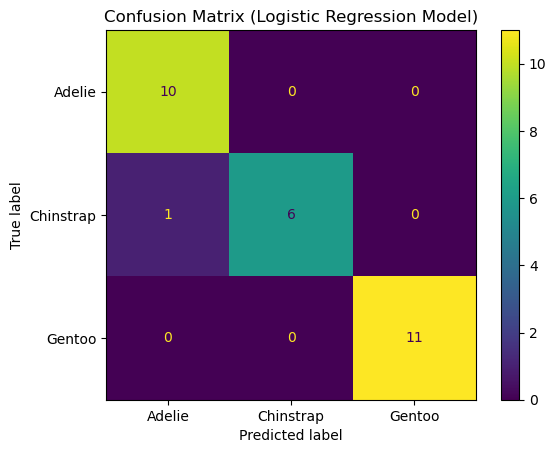

In [164]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=logi_reg)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["Adelie", "Chinstrap", 'Gentoo'])
cm_display.plot()
plt.title("Confusion Matrix (Logistic Regression Model)");

#### Random Forest Classifier

In [165]:
from sklearn.ensemble import RandomForestClassifier
model_2 = RandomForestClassifier()
model_2.fit(X_train,y_train)

RandomForestClassifier()

In [166]:
model_2.score(X_train,y_train)

1.0

Accuracy: 96.43%


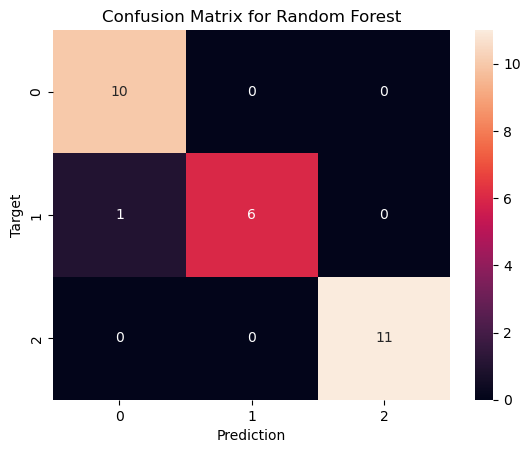

In [167]:
def predict_and_plot(model, inputs,targets):
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(cf, annot = True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Confusion Matrix for Random Forest')
    
    return preds

val_preds = predict_and_plot(model_2, X_test, y_test)

##### I didn't do hyprerparameter tuning for random forest due to its computational intensiveness

#### Support Vector Classifier

In [168]:
from sklearn import svm

In [169]:
suvec = svm.SVC()

In [170]:
suvec.fit(X_train, y_train)

SVC()

In [171]:
from sklearn.linear_model import LogisticRegression

parar= {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': [0.1,1,10]
}
       
suvecs = GridSearchCV(suvec, parar)
suvecs.fit(X_train, y_train)

best_params = suvecs.best_params_
best_score = suvecs.best_score_

print('Best parameter:', best_params)
print('Best score:', best_score)

Best parameter: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best score: 1.0


Accuracy Score is:  1.0
F1 Score is:  1.0
Recall Score is:  1.0
Precision Score is:  1.0
Precision Score is:  1.0


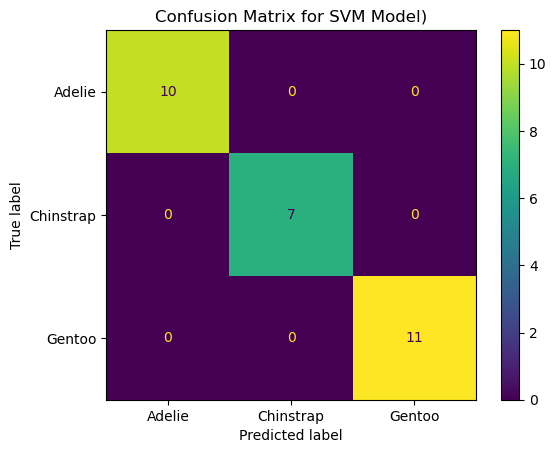

In [172]:
AccuracyScore = []
f1score =[]
RecallScore = []
PrecisionScore = []

parar= {
    'C': 0.1,
    'kernel': 'linear',
    'gamma': 0.1
}

fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    svm_model = svm.SVC(**parar)
    svm_model.fit(X_train, y_train)

    svm_model = svm_model.predict(X_test)
    acc_score= accuracy_score(y_test, svm_model)
    f1 = f1_score(y_test, svm_model, average='weighted')
    recall= recall_score(y_test, svm_model, average='weighted')
    precision= precision_score(y_test, svm_model, average='weighted')
    
AccuracyScore.append(acc_score)
f1score.append(f1)
RecallScore.append(recall)
PrecisionScore.append(precision)

print("Accuracy Score is: ", np.mean(AccuracyScore))
print("F1 Score is: ", np.mean(f1score))
print("Recall Score is: ", np.mean(RecallScore))
print("Precision Score is: ", np.mean(PrecisionScore))
print("Precision Score is: ", np.mean(PrecisionScore))

confuison_matrix = confusion_matrix(y_true=y_test, y_pred=svm_model)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["Adelie", "Chinstrap", 'Gentoo'])
cm_display.plot()
plt.title("Confusion Matrix for SVM Model)");

#### Trying to build the model with unfilled dataset

In [173]:
peng_p = peng_quin.copy()

In [174]:
col_to_encode = ["species", "island", "clutch", 'sex', 'culmenL_cat', 'culmenD_cat', 'flipperL_cat', 'bmass_cat']

label_encoder = LabelEncoder()
for col in col_to_encode:
    peng_p[col] = label_encoder.fit_transform(peng_p[col]) 

In [175]:
X1 = peng_p.drop(columns=['species'])
y1 = peng_p[['species']]

In [176]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)

#### Xgboost

In [177]:
AccuracyScore = []
f1score =[]
RecallScore = []
PrecisionScore = []

params = {
    "n_estimators": 500,
    "learning_rate": 0.09,
    "random_state": 42,
#     "enable_categorical": True 
}

fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in fold.split(X1,y1):
    x1_train, x1_test = X1.iloc[train_index], X1.iloc[test_index]
    y1_train, y1_test = y1.iloc[train_index], y1.iloc[test_index]
    
    xgboost = XGBClassifier(**params)
    xgb = xgboost.fit( x1_train, y1_train)
    xgb = xgboost.predict(x1_test)
    
    acc_score= accuracy_score(y1_test, xgb)
    f1= f1_score(y1_test, xgb, average='weighted')
    recall= recall_score(y1_test, xgb, average='weighted')
    precision= precision_score(y1_test, xgb, average='weighted')
    
AccuracyScore.append(acc_score)
f1score.append(f1)
RecallScore.append(recall)
PrecisionScore.append(precision)

print("Accuracy Score is: ", np.mean(AccuracyScore))
print("F1 Score is: ", np.mean(f1score))
print("Recall Score is: ", np.mean(RecallScore))
print("Precision Score is: ", np.mean(PrecisionScore))

Accuracy Score is:  0.9642857142857143
F1 Score is:  0.9637624280481424
Recall Score is:  0.9642857142857143
Precision Score is:  0.9675324675324675


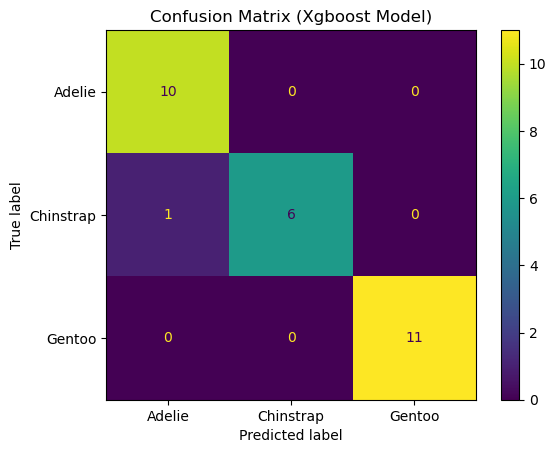

In [178]:
confuison_matrix = confusion_matrix(y_true=y1_test, y_pred=xgb)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["Adelie", "Chinstrap", 'Gentoo'])
cm_display.plot()
plt.title("Confusion Matrix (Xgboost Model)");

Accuracy Score is:  0.9642857142857143
F1 Score is:  0.9637624280481424
Recall Score is:  0.9642857142857143
Precision Score is:  0.9675324675324675


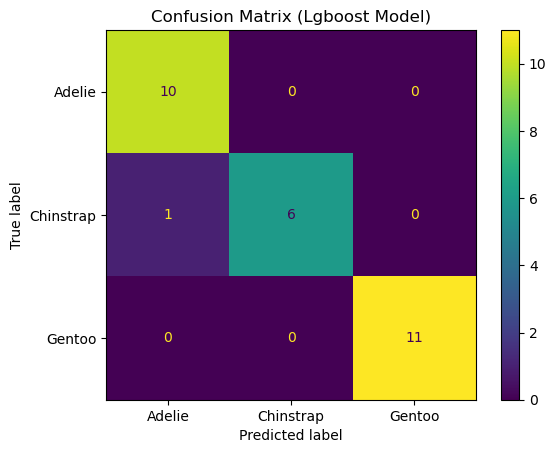

In [179]:
AccuracyScore = []
f1score =[]
RecallScore = []
PrecisionScore = []

params1 = {
    "n_estimators": 500,
    "learning_rate": 0.091,
    "random_state": 42,
    'verbose': -1
}

fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in fold.split(X1,y1):
    x1_train, x1_test = X1.iloc[train_index], X1.iloc[test_index]
    y1_train, y1_test = y1.iloc[train_index], y1.iloc[test_index]
    
    lgb = LGBMClassifier(**params1)
    lgboost = lgb.fit(x1_train, y1_train)
    lgboost = lgb.predict(x1_test)
    
    lgboost = np.round(lgboost)
    
    acc_score= accuracy_score(y1_test, lgboost)
    f1= f1_score(y1_test, lgboost, average='weighted')
    recall= recall_score(y1_test, lgboost, average='weighted')
    precision= precision_score(y1_test, lgboost, average='weighted')
    
AccuracyScore.append(acc_score)
f1score.append(f1)
RecallScore.append(recall)
PrecisionScore.append(precision)

print("Accuracy Score is: ", np.mean(AccuracyScore))
print("F1 Score is: ", np.mean(f1score))
print("Recall Score is: ", np.mean(RecallScore))
print("Precision Score is: ", np.mean(PrecisionScore))

confuison_matrix = confusion_matrix(y_true=y1_test, y_pred=lgboost)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["Adelie", "Chinstrap", 'Gentoo'])
cm_display.plot()
plt.title("Confusion Matrix (Lgboost Model)");

In [180]:
joblib.dump(log_reg, "logistic 3.pkl")

['logistic 3.pkl']